# Home Price Prediction Machine Learning Model (using BHI data)

Predict home price based on location, brand, square footage, number of bedrooms, number of batchrooms, garage size, and number of stories.  Predictions can then be compared to the actual home price to determine which homes are over and underpriced in their respective markets.  This model can also be used to help determine a price for a new home or exisitng home before it is put on the market.

This notebook demonstrates the following capabilities:

* Reads in CSV data which includes two very large catigory columns which are processed using embedding rather than one hot encoding.
* Encodes category/enumerations putting them in the format needed for training the model.  These include both ordered and unordered categories.
* Trains the model showing a plot of convergence rate allowing for easy adjustment of the learning rate, epochs, and hidden size for best training efficiency and final accuracy.
* Saves the trained model to disk, and later loads back in that model for price predictions.
* Calculates and displays final model accuracy percentage.
* Scatter plots all home actual vs predicted prices as another method of displaying final model accuracy.
* Plots line overlay of all home actual vs predicted prices helping show visually stocks that deviate most from the model’s prediction.
    * This plot is shown twice; once to help show overpriced homes, and once to help show underpriced homes
* Outputs a spreadsheet showing homes including all metrics used to predict the price, both the actual and predicted price, and the percentage difference between those prices denoting how much a home is either overpriced or underpriced.

A Mac M1 Pro using CPU takes around 58 seconds to train this model to a high level of accuracy (~93%).

Also make sure to look at the related notebooks named `housing_growth.ipynb` and `builder_locations.ipynb`

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchviz import make_dot

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [228]:
input_df = pd.read_csv('../inputs/home_sales_bhi.csv')
# Prep input data for use for later reporting
input_df = input_df.rename(columns={
    'BHIBrandName': 'Brand',
    'BHIState': 'State',
    'BHICity': 'City',
    'BHIZip': 'Zip',
    'PlanName': 'PlanName'    
})
input_df = input_df.drop(['IndustryPlanID'], axis=1)
input_df = input_df.reindex(columns=['Brand', 'PlanName', 'City', 'State', 'Zip', 'BaseSqFt', 'Bedrooms', 'Baths', 'Garage', 'Stories', 'BasePrice'])
input_df['Zip'] = input_df['Zip'].astype('str').str.rstrip('.0')
input_df = input_df.dropna()
input_df = input_df.groupby(['Brand', 'PlanName', 'City', 'State', 'Zip'], as_index=False).mean(numeric_only=True)
# Remove homes where data is outside the realms of realistic for putposes of this model
print(input_df.shape)
input_df = input_df[
    (input_df['Zip'] != 'nan')
    & (input_df['BasePrice'] >= 50000)
    & (input_df['BasePrice'] <= 3000000)
    & (input_df['BaseSqFt'] >= 1000)
    & (input_df['BaseSqFt'] <= 10000)
    & (input_df['Bedrooms'] > 0)
    & (input_df['Bedrooms'] <= 10)
    & (input_df['Baths'] > 0)
    & (input_df['Baths'] <= 10)
    & (input_df['Garage'] >= 0)
    & (input_df['Garage'] <= 6)
    & (input_df['Stories'] > 0)
    & (input_df['Stories'] <= 3)
]
print(input_df.shape)
input_df = input_df.reset_index(drop=True)
input_df.head()

(34873, 11)
(34693, 11)


,Brand,PlanName,City,State,Zip,BaseSqFt,Bedrooms,Baths,Garage,Stories,BasePrice
0,ABD Development,Courtyard 50,Davenport,FL,33837,2530.0,4.0,3.0,2.0,2.0,594000.0
1,ABD Development,Marbella 3BR,Davenport,FL,33837,1904.0,3.0,2.0,2.0,1.0,475000.0
2,ABD Development,Marbella 4BR,Davenport,FL,33837,2192.0,4.0,3.0,2.0,1.0,536000.0
3,ABD Development,Sienna,Davenport,FL,33837,2293.0,4.0,3.0,2.0,1.0,650000.0
4,ABD Development,The Bristol,Palm Coast,FL,32137,5021.0,4.0,4.0,3.0,2.0,1110000.0


In [229]:
# Separate dataframe into features, and target.  
target_df = pd.DataFrame({'BasePrice': input_df['BasePrice']})
# Remove target column and any column only used for reporting (not training)
features_df = input_df.drop(['BasePrice', 'City', 'State', 'PlanName'], axis=1)
# BHIBrandName and BHIZip are categories but too large to one hot encode them, so instead represent them as embeddings
features_df['Brand'] = pd.Categorical(features_df['Brand']) # Convert string to category
features_df['Zip'] = pd.Categorical(features_df['Zip']) # Convert string to category
num_brand_embeddings = len(features_df['Brand'].cat.categories)
num_zip_embeddings = len(features_df['Zip'].cat.categories)
num_in_features = 5 # Non-embedded features
# Create dictionaries for all embeddings that we can save with the model for use in other application that use the model
brand_dictionary = dict(enumerate(features_df['Brand'].cat.categories))
zip_dictionary = dict(enumerate(features_df['Zip'].cat.categories))
print(f'Dataset size = {features_df.shape[0]}')
print(f'Number of unique brands = {num_brand_embeddings}')
print(f'Number of unique zip codes = {num_zip_embeddings}')
print(f'Number of additional input parameters = {num_in_features}')
print(f'Total input parameters (per home) = {num_brand_embeddings + num_zip_embeddings + num_in_features}')
features_df.head()

Dataset size = 34693
Number of unique brands = 313
Number of unique zip codes = 1563
Number of additional input parameters = 5
Total input parameters (per home) = 1881


,Brand,Zip,BaseSqFt,Bedrooms,Baths,Garage,Stories
0,ABD Development,33837,2530.0,4.0,3.0,2.0,2.0
1,ABD Development,33837,1904.0,3.0,2.0,2.0,1.0
2,ABD Development,33837,2192.0,4.0,3.0,2.0,1.0
3,ABD Development,33837,2293.0,4.0,3.0,2.0,1.0
4,ABD Development,32137,5021.0,4.0,4.0,3.0,2.0


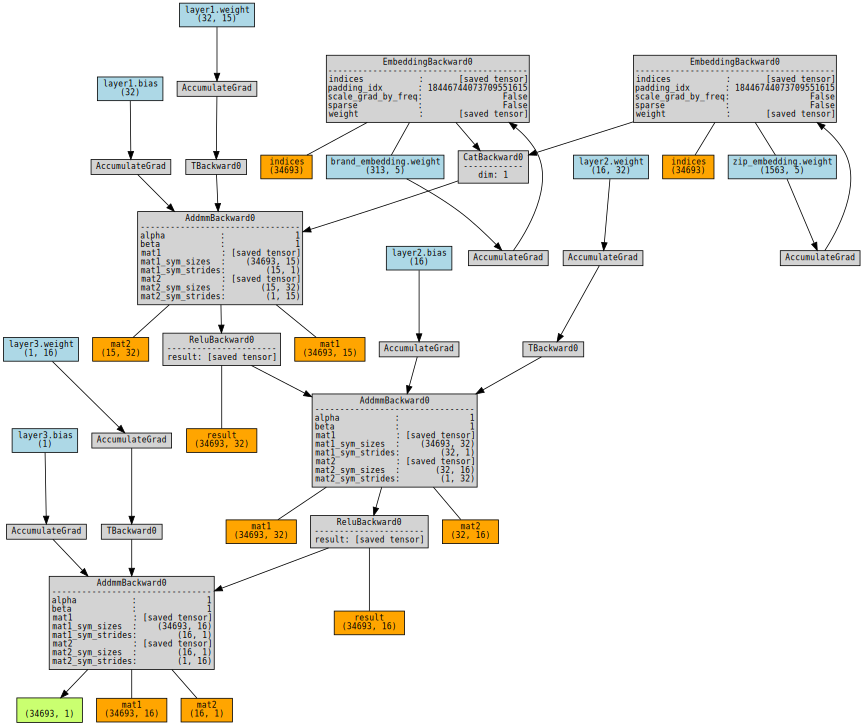

In [239]:
# Convert dataframes to dataset
class MyDataset(Dataset):
    def __init__(self, input_df, target_df):
        self.brand_tensor = torch.tensor(input_df['Brand'].cat.codes.values, dtype=torch.float32).to(device)
        self.zip_tensor = torch.tensor(input_df['Zip'].cat.codes.values, dtype=torch.float32).to(device)
        self.input_tensor = torch.tensor(input_df[['BaseSqFt', 'Bedrooms', 'Baths', 'Garage', 'Stories']].values, dtype=torch.float32).to(device)
        self.target_tensor = torch.tensor(target_df.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.input_tensor) # Number of rows in our input dataset
    def __getitem__(self, idx):
        return self.brand_tensor[idx], self.zip_tensor[idx], self.input_tensor[idx], self.target_tensor[idx]
    def get_tensors(self):
        return self.brand_tensor, self.zip_tensor, self.input_tensor, self.target_tensor

# Define PyTorch model
class MyModel(nn.Module):
    def __init__(self, in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary):
        super(MyModel, self).__init__()
        embedding_dim = 5 # Size of each embedding vector (tunable during training)
        hidden_dim = 16 # Dimensions used for the inner layers of the model
        self.brand_dictionary = brand_dictionary
        self.zip_dictionary = zip_dictionary
        self.brand_embedding = nn.Embedding(num_brand_embeddings, embedding_dim)
        self.zip_embedding = nn.Embedding(num_zip_embeddings, embedding_dim)
        in_features = embedding_dim*2 + in_features
        self.layer1 = nn.Linear(in_features, hidden_dim*2)
        self.layer2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, brand_tensor, zip_tensor, input_tensor):
        brand_tensor = self.brand_embedding(brand_tensor.to(torch.int))
        zip_tensor = self.zip_embedding(zip_tensor.to(torch.int))
        # Concat all tensors after creating embedding vectors, then pass them into the first layer
        x = torch.cat([brand_tensor, zip_tensor, input_tensor], dim=1)
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

dataset = MyDataset(features_df, target_df)
model = model = MyModel(num_in_features, num_brand_embeddings, num_zip_embeddings, brand_dictionary, zip_dictionary).to(device)
brand_train_tensor, zip_train_tensor, x_train_tensor, target_tensor = dataset.get_tensors()
make_dot(model(brand_train_tensor, zip_train_tensor, x_train_tensor), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [240]:
# Training Tuning Parameters
# Start with 500 epochs, 0.00001 learn rate, and 3 layers each with a hidden_dim of 300
batch_size = 64
learning_rate = 0.01
num_epochs = 100
# Choose the best loss and optimizer functions
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Split the data and setup the data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Training Size = {train_size}')
print(f'Test Size = {test_size}')

Training Size = 27754
Test Size = 6939


Epoch 5 (5%), Loss: 40782624
Epoch 10 (10%), Loss: 12459258
Epoch 15 (15%), Loss: 5073075
Epoch 20 (20%), Loss: 3044852
Epoch 25 (25%), Loss: 2238091
Epoch 30 (30%), Loss: 1760627
Epoch 35 (35%), Loss: 1488772
Epoch 40 (40%), Loss: 1259148
Epoch 45 (45%), Loss: 1325870
Epoch 50 (50%), Loss: 986293
Epoch 55 (55%), Loss: 909852
Epoch 60 (60%), Loss: 821656
Epoch 65 (65%), Loss: 762445
Epoch 70 (70%), Loss: 677505
Epoch 75 (75%), Loss: 627038
Epoch 80 (80%), Loss: 594241
Epoch 85 (85%), Loss: 588336
Epoch 90 (90%), Loss: 506448
Epoch 95 (95%), Loss: 574240
Epoch 100 (100%), Loss: 443808


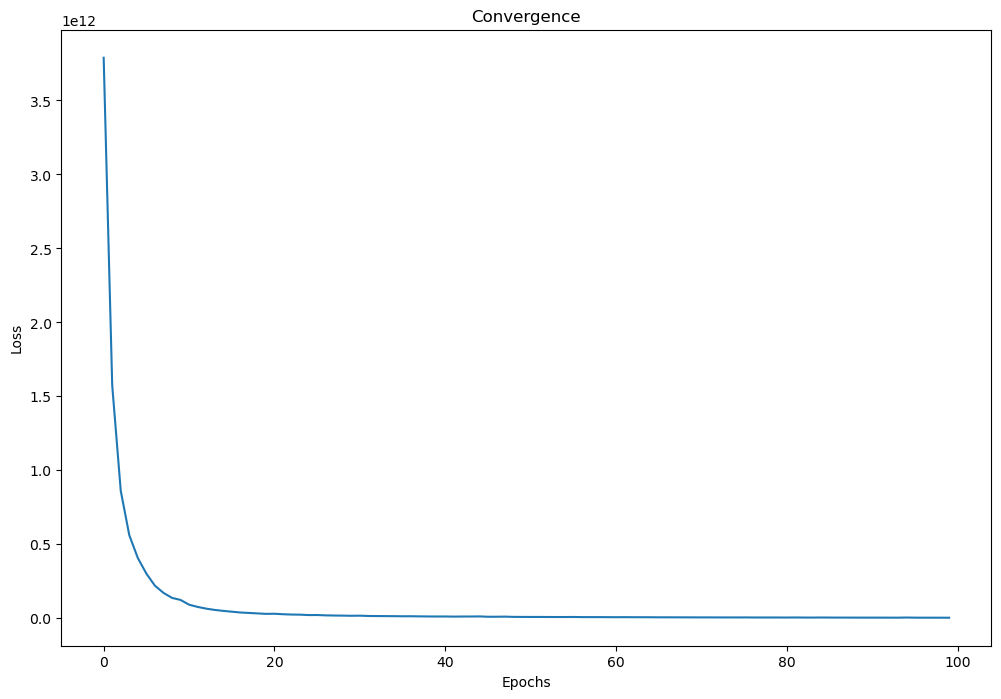

In [241]:
# Train the model and plot convergence
def train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs):
    plot_losses = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            brand_tensor, zip_tensor, input_tensor, target_tensor = data
            optimizer.zero_grad()
            output_tensor = model(brand_tensor, zip_tensor, input_tensor)
            loss = criterion(output_tensor, target_tensor)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                brand_tensor, zip_tensor, input_tensor, target_tensor = data
                output_tensor = model(brand_tensor, zip_tensor, input_tensor)
                loss = criterion(output_tensor, target_tensor)
                total_loss += loss.item()
        if epoch % (num_epochs/20) == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch/10000:.0f}') # /100 to simplify display only
        plot_losses.append(total_loss/epoch)
    return plot_losses

# Train the model and plot convergence
plot_losses = train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs)
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [242]:
# Save model to file
path = '../api/home_price_model_bhi.pth'
torch.save(model, path)
saved_model = torch.load(path)

def getAccuracyPercentage(list1, list2):
    mean_abs_diff = np.mean(np.abs(list1 - list2))
    mean_orig = np.mean([list1, list2])
    return 100 - mean_abs_diff / mean_orig * 100

# Test the model's accuracy
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    accuracy_percent = getAccuracyPercentage(y_predicted, y_actual)
    print(f"Test Accuracy: {accuracy_percent:>0.1f}%")

Test Accuracy: 93.3%


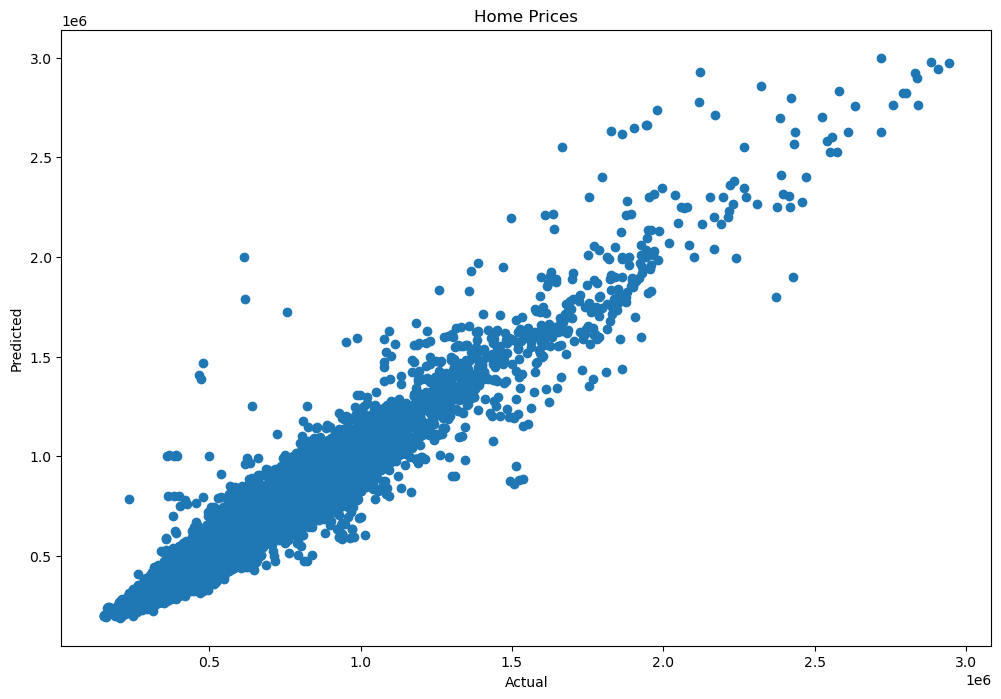

In [243]:
# Scatter plot results to show accuracy (45% upward, rightward slope scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_actual)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Home Prices")
plt.show()

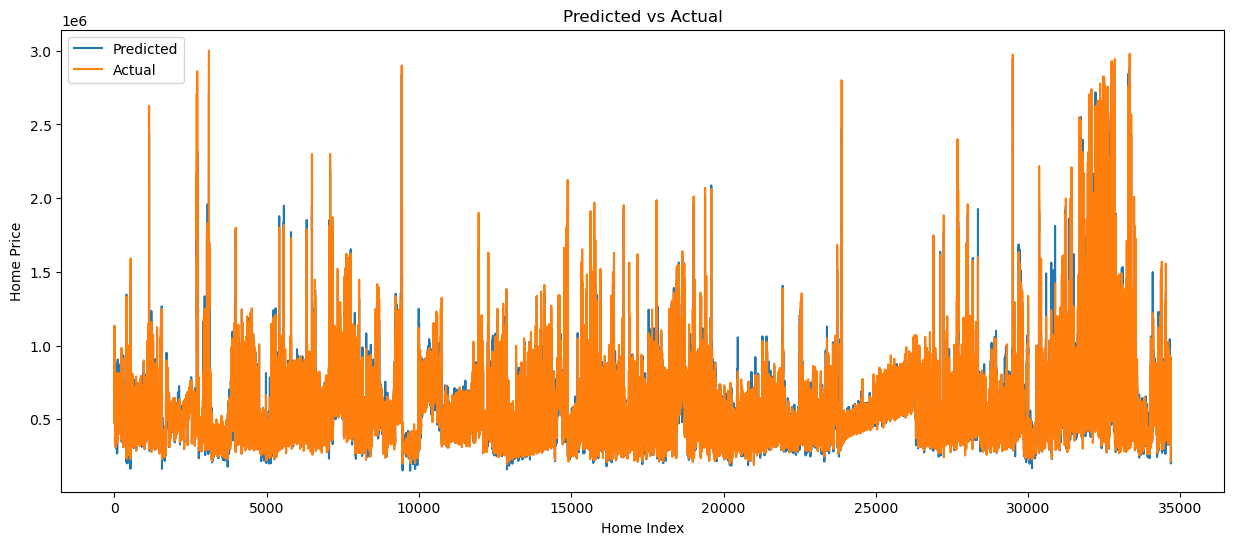

In [244]:
# Show accuracy by overlaying actual vs pridicted prices
# Orange on top helps underpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.title("Predicted vs Actual")
plt.xlabel("Home Index")
plt.ylabel("Home Price")
plt.legend()
plt.show()

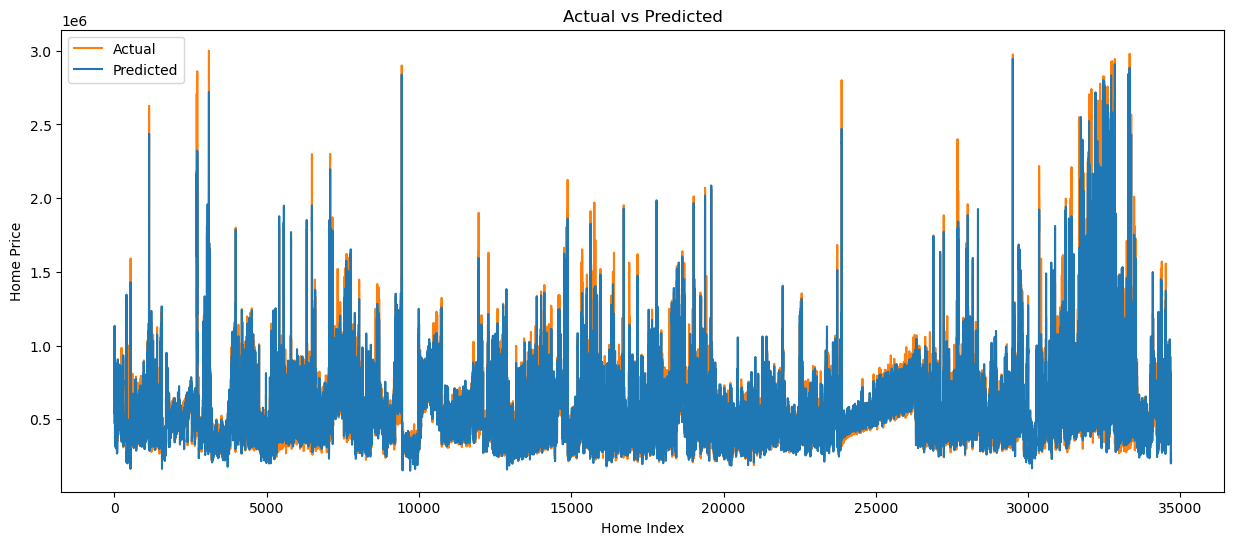

In [245]:
# Inverse the plot so blue is on top.  This helps high overpriced homes stand out
plt.figure(figsize=(15,6))
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Home Index")
plt.ylabel("Home Price")
plt.legend()
plt.show()

In [246]:
# Run predictions for the full dataset
saved_model.eval()
brand_tensor, zip_tensor, input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(brand_tensor, zip_tensor, input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    predicted_price_difference = (y_predicted - y_actual) / ((y_predicted + y_actual) / 2) * 100
    accuracy_percent = 100-abs(np.average(predicted_price_difference))
# Generate and save to disk a new table with both actual and predicted prices for just those stocks where the prices differ by over 10%
output_df = input_df.copy()
output_df['Predicted Price'] = y_predicted.round()
output_df['% Difference'] = predicted_price_difference
output_df.to_csv('../outputs/home_prices_bhi.csv', index=False)
# Sort so the prices that are too low go to the top
output_df = output_df.sort_values(by='% Difference', ascending=False)
# Homes selling too low
output_df.sample(10, ignore_index=True)

,Brand,PlanName,City,State,Zip,BaseSqFt,Bedrooms,Baths,Garage,Stories,BasePrice,Predicted Price,% Difference
0,Lennar,JACKSON,Summerville,SC,29486,2610.0,3.0,3.0,2.0,2.0,500000.0,481964.0,-3.673389
1,Lennar,Lewis,Woodbury,MN,55129,2692.0,4.0,2.0,2.5,2.0,564990.0,551989.0,-2.327807
2,Gehan Homes,Classic Series - Dartmouth,Leander,TX,78641,3390.0,4.0,2.0,3.0,2.0,694990.0,655191.0,-5.895387
3,Highland Homes,Plan 504,Argyle,TX,76226,2295.0,4.0,3.0,3.0,1.0,550990.0,577633.0,4.721372
4,Kay Builders,Blanchard II,Emmaus,PA,18049,2108.0,3.0,3.0,2.0,2.0,441900.0,436728.0,-1.177319
5,Coventry Homes,Ackerly,Fort Worth,TX,76179,1843.0,4.0,2.0,2.0,1.0,381990.0,373450.0,-2.260892
6,Lennar,Tivoli,Dunnellon,FL,34432,2267.0,4.0,3.0,0.0,1.0,335990.0,343222.0,2.129490
7,True Homes - Triad,The Declan,Greensboro,NC,27405,1686.0,2.0,2.0,2.0,1.0,345900.0,290044.0,-17.566198
8,Impression Homes,Brownwood,Mansfield,TX,76063,2043.0,3.0,2.0,2.0,2.0,374990.0,366548.0,-2.277009
9,Oakwood Homes,Yampa,Colorado Springs,CO,80927,2229.0,3.0,3.0,2.0,2.0,462900.0,486693.0,5.011168


In [247]:
shap_length = 100 # Reduce the size of the tensor so explanation does not take too long
X = [brand_tensor[:shap_length], zip_tensor[:shap_length], input_tensor[:shap_length, :]]
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)
feature_names = list(features_df.columns)
shap.summary_plot(shap_values, X, feature_names=feature_names)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


IndexError: tuple index out of range